In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra


In [2]:
# load preproc functions
%run ./preproc_functions.py



In [3]:
# set sub and ori lists
# sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL10', 'LL12', 'LL13', 'LL17', 'LL19']
# sub_list = ['BJH041', 'LL10', 'LL12', 'LL13', 'LL17', 'LL19']
sub_list = ['LL14']
roi_list = ['hc', 'amyg', 'ofc', 'cing', 'dlpfc', 'insula']
# roi_list = ['dlpfc', 'insula']


In [5]:
for sub in sub_list:
    # load in raw data to get good epochs #
    trial_onset_epochs = mne.read_epochs(f"/home/brooke/pacman/preprocessing/{sub}/ieeg/{sub}_bp_clean_pres-locked_ieeg.fif")
    # get good epochs (for behavioral data only)
    good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]
    
    for roi in roi_list:
        
        if sub == 'LL14':
            good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x and i not in [485, 486, 487, 488, 543, 544, 545, 704, 705, 710, 711, 712, 713, 714]]

        try:
            # load TFR
            roi_pres_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{sub}/ieeg/trial_onset/{roi}-tfr.h5")
            roi_pres_TFR = roi_pres_TFR[0]
        except Exception as e:
            print(f"An error occurred with region {roi} and subject {sub}: {e}")
            continue
        
        # baseline by 1 seconds before
        roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,0), logflag=True)
        
        ## extract freq info
        # delta
        extract_freqs(1, 3, "delta", f"{sub}/ieeg/trial_onset", roi, "onset_locked_logged_itibase", roi_pres_TFR, good_epochs)
        # theta
        extract_freqs(3, 8, "theta", f"{sub}/ieeg/trial_onset", roi, "onset_locked_logged_itibase", roi_pres_TFR, good_epochs)
        # alpha
        extract_freqs(8, 13, "alpha", f"{sub}/ieeg/trial_onset", roi, "onset_locked_logged_itibase", roi_pres_TFR, good_epochs)
        # beta
        extract_freqs(13, 30, "beta", f"{sub}/ieeg/trial_onset", roi, "onset_locked_logged_itibase", roi_pres_TFR, good_epochs)
        # gamma
        extract_freqs(30, 70, "gamma", f"{sub}/ieeg/trial_onset", roi, "onset_locked_logged_itibase", roi_pres_TFR, good_epochs)
        # HFA
        extract_freqs(70, 150, "hfa", f"{sub}/ieeg/trial_onset", roi, "onset_locked_logged_itibase", roi_pres_TFR, good_epochs)
        

Reading /home/brooke/pacman/preprocessing/LL14/ieeg/LL14_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_96474/148302029.py:3: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/LL14/ieeg/LL14_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"/home/brooke/pacman/preprocessing/{sub}/ieeg/{sub}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/LL14/ieeg/LL14_bp_clean_pres-locked_ieeg-1.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Not setting metadata
819 matching events found
No baseline correction applied
0 projection items activated
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/LL14/ieeg/trial_onset/hc-tfr.h5 ...
Not setting metadata
log transforming
z-scoring to baseline
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/LL14/ieeg/trial_onset/amyg-tfr.h5 ...
Not setting metadata
log transforming
z-scoring to baseline
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/LL14/ieeg/trial_onset/ofc-tfr.h5 ...
Not setting metadata
log transforming
z-scoring to baseline
Reading /home/brooke/knight_server/remote/bstavel/pacman/p

## Compare the differences between baseline options

In [82]:
roi_pres_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/ofc-tfr.h5")

Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns


In [83]:
roi_pres_TFR = roi_pres_TFR[0]
        
# baseline by 1 seconds before
roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,0), logflag=True)

log transforming
z-scoring to baseline


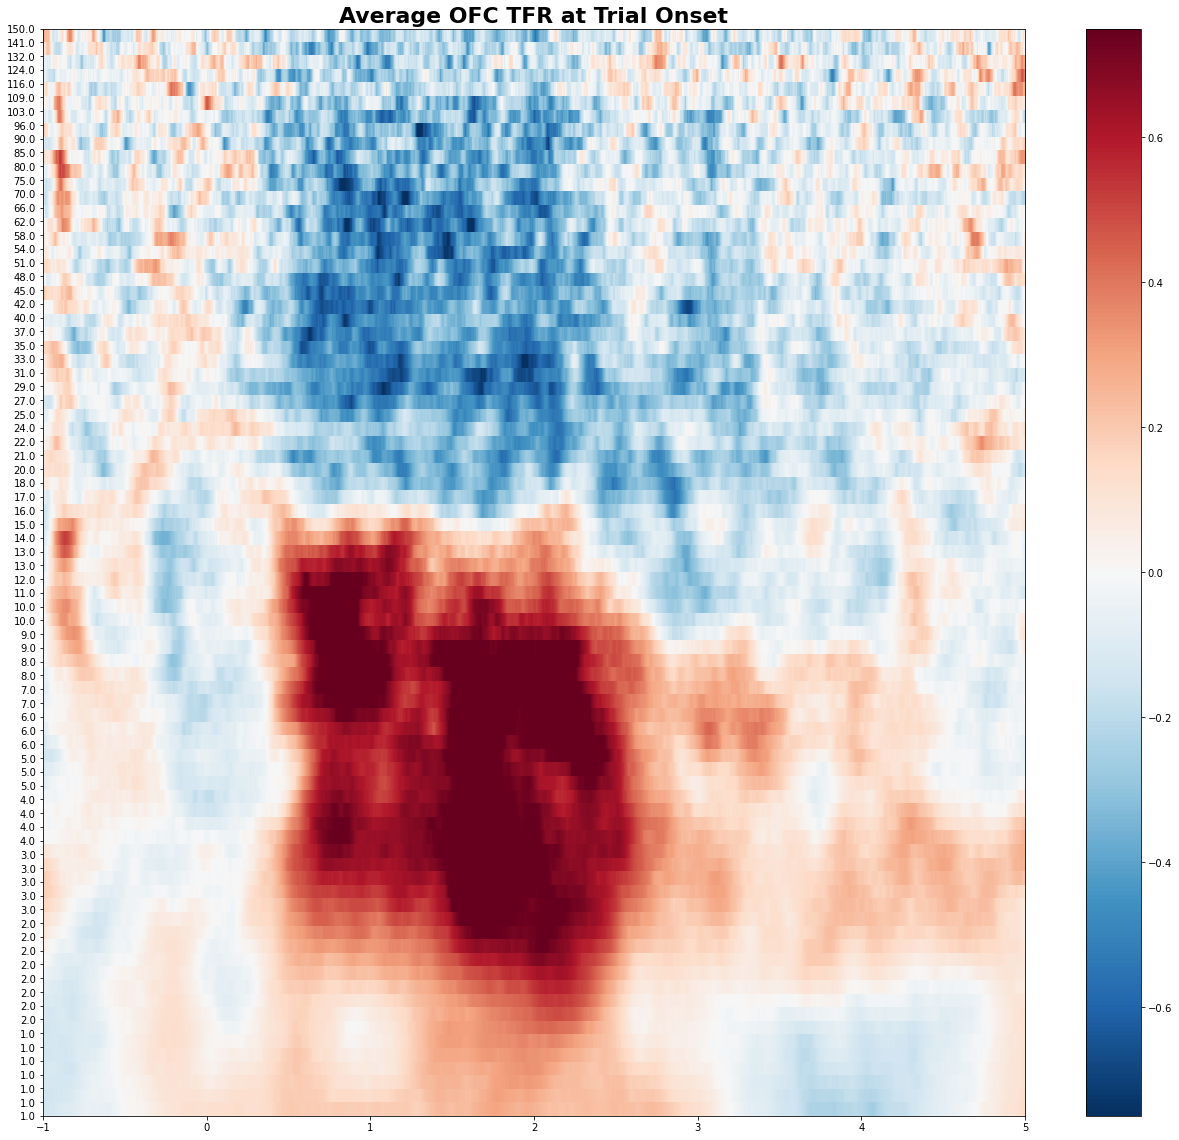

In [87]:
plt.rcParams['figure.figsize'] = [22, 20]

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.75, vmax = .75)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average OFC TFR at Trial Onset", fontsize=22, fontweight = 'bold')
fig.show()

In [78]:
roi_pres_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/ofc-tfr.h5")

Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns


In [79]:
roi_pres_TFR = roi_pres_TFR[0]
        
# baseline by 1 seconds before
roi_pres_TFR = log_and_zscore_TFR(roi_pres_TFR, baseline = (-1,0), logflag=True)

log transforming
z-scoring to baseline


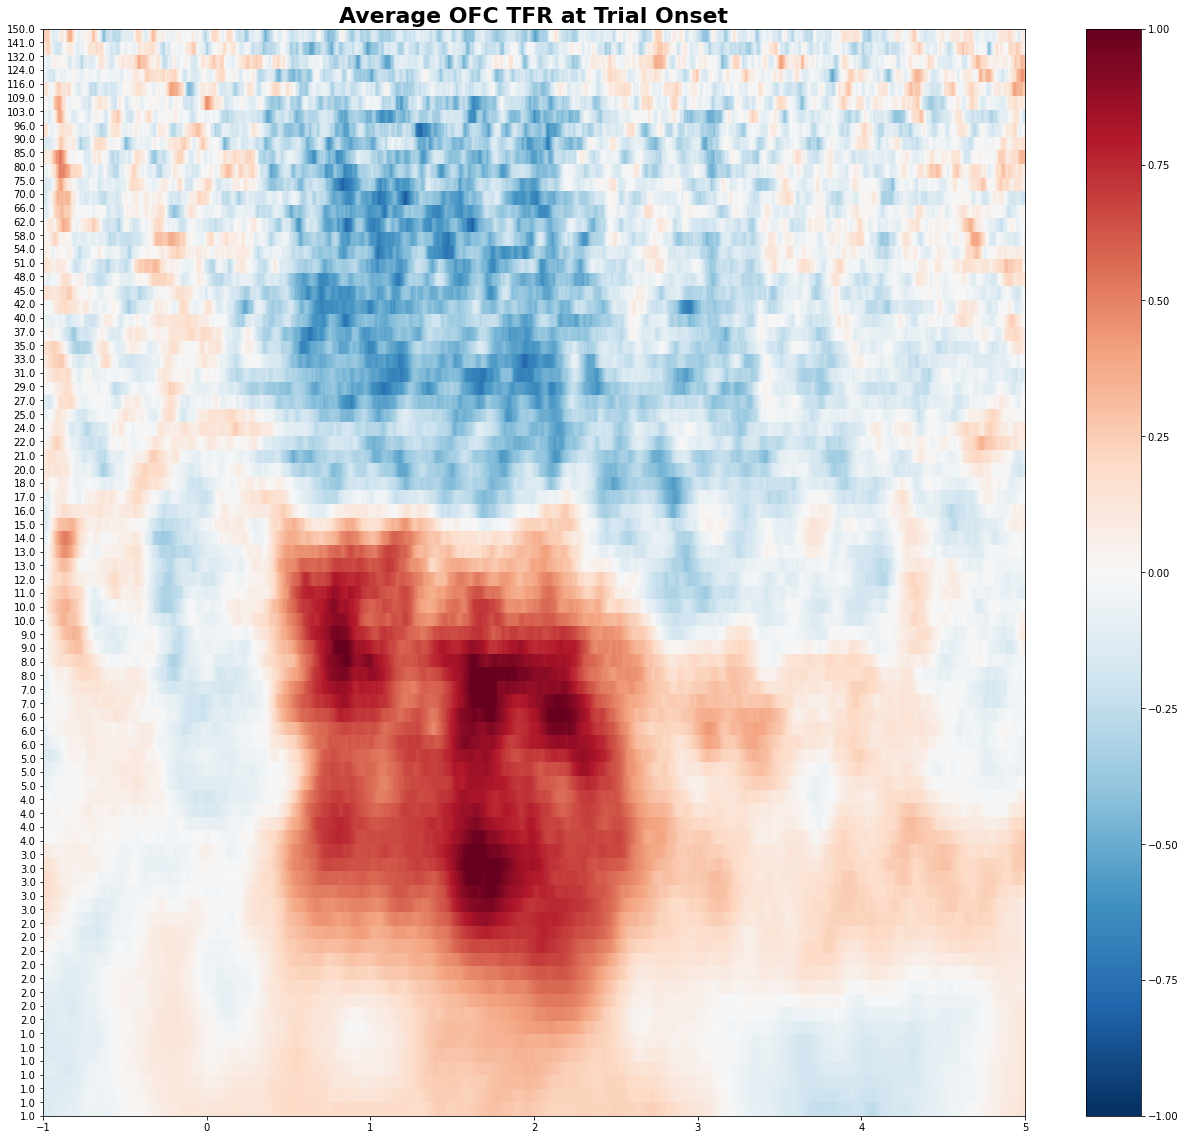

In [81]:
plt.rcParams['figure.figsize'] = [22, 20]

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average OFC TFR at Trial Onset", fontsize=22, fontweight = 'bold')
fig.show()